In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothicCoding'
# fontPath = '/home/ubuntu/miniconda3/envs/foru/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/GmarketSansTTFBold.ttf'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = 16,8




import warnings
warnings.filterwarnings('ignore')

import imshow
from wordcloud import WordCloud
from PIL import Image

from itertools import chain

import re
from konlpy.tag import Okt, Mecab
import nltk
from nltk.corpus import stopwords


from collections import Counter
import pickle

import sent2vec
import hnswlib
from gensim.models import Word2Vec
from gensim import corpora
from scipy.sparse import *
from scipy.sparse.linalg import svds


# -------
with open('/home/ubuntu/workspace/jh/project/data/10_28_stopword.pickle','rb') as file:
    stopword = pickle.load(file)

m = Mecab('/home/ubuntu/workspace/mecab-ko-dic-2.1.1-20180720')

from py_file.total_processing import konlpy_preprocessing
kp = konlpy_preprocessing()

In [4]:
train = pd.read_json('/home/ubuntu/workspace/jh/project/data/1108_new_train.json')
train.head(3)

,tags,id,new_tags,plylst_title,songs,like_cnt,updt_date
0,[락],61281,"[여행, 락]",여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,"[회상, 추억]",요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"[편하, 까페, 잔잔]","편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000


In [5]:
w2v_model = Word2Vec.load('model/w2v.model')
p_tags = pickle.load(open('/home/ubuntu/workspace/jh/project/model/w2v_p_tags.pickle', 'rb'))
p_titles = pickle.load(open('/home/ubuntu/workspace/jh/project/model/w2v_p_titles.pickle', 'rb'))
p_new_tags = pickle.load(open('/home/ubuntu/workspace/jh/project/model/w2v_p_new_tags.pickle', 'rb'))

In [6]:
def w2v_visual(text, k_n = 10):
    # print(text)
    try:
        test_tag = kp.konlpy_preprocessing(text)

        test_tag = test_tag.split()
        x = []
        for i in test_tag:
            vec = w2v_model.wv.get_vector(i)
            x.append(vec)
        
        emb = sum(x)/len(x)

        title_labels, title_distances = p_titles.knn_query(emb, k = k_n, num_threads=8)
        tag_labels, tags_distances = p_tags.knn_query(emb, k = k_n, num_threads=8)
        new_tag_labels, new_tags_distances = p_new_tags.knn_query(emb, k = k_n, num_threads=8)

        reco_idx = list(chain.from_iterable(zip(title_labels.reshape(-1),tag_labels.reshape(-1),new_tag_labels.reshape(-1))))

        count = Counter(np.concatenate(train.iloc[reco_idx]['tags'].tolist()))
        words = dict(count.most_common())
        
        fig, ax = plt.subplots()
        wc = WordCloud(font_path=r'/home/ubuntu/workspace/font/GmarketSansTTFMedium.ttf',
                        max_words=100,
                        background_color='white',
                        color_func = color_func,
                        relative_scaling  = 0.2,
                        stopwords=stopword,
                        width = 3000,
                        height = 2000)

        wc.generate_from_frequencies(words)

        ax.imshow(wc,interpolation='bilinear')
        ax.axis('off')
        # ax.set_title('{text}')
            
        plt.show()
        # plt.savefig(f'/home/ubuntu/workspace/fffff/word2vec_{text}.png',dpi=1000)

        return reco_idx
    except KeyError:
        print('다시 입력해주세요')

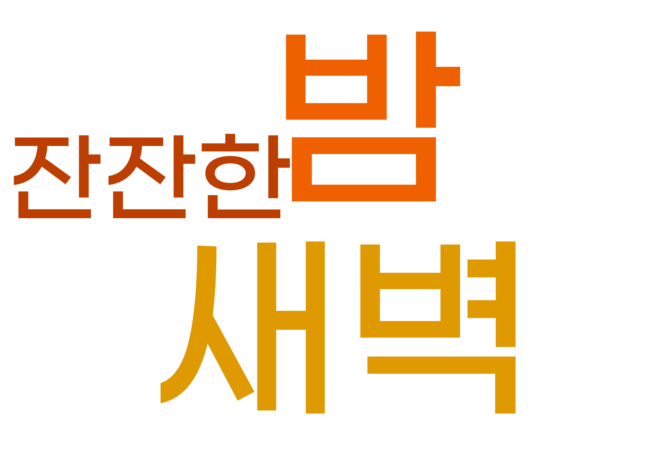

In [7]:
def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return(f"hsl({np.random.randint(18,45)},{np.random.randint(99,100)}%, {np.random.randint(30,70)}%)")

x = w2v_visual('밤이나 새벽에 듣기 좋은 잔잔한 노래')